# Graph-PRefLexOR Sample Training Script

```bibtext
@article{buehler2024PRefLexOR,
      title={PRefLexOR: Preference-based Recursive Language Modeling for Exploratory Optimization of Reasoning and Agentic Thinking}, 
      author={Markus J. Buehler},
      year={2024},
      eprint={2410.12375},
      archivePrefix={arXiv},
      primaryClass={cs.AI},
      url={https://arxiv.org/abs/2410.12375}, 
}
@misc{buehler2025insitugraphreasoningknowledge,
      title={In-situ graph reasoning and knowledge expansion using Graph-PReFLexOR}, 
      author={Markus J. Buehler},
      year={2025},
      eprint={2501.08120},
      archivePrefix={arXiv},
      primaryClass={cs.AI},
      url={https://arxiv.org/abs/2501.08120}, 
}
```

This script shows an example how the two training phases I and II are implemented

### Graph-PReFLexOR: In-situ graph reasoning 

Graph-PReFLexOR (Graph-based Preference-based Recursive Language Modeling for Exploratory Optimization of Reasoning) is a framework that combines graph reasoning with symbolic abstraction to dynamically expand domain knowledge. Inspired by reinforcement learning, Graph-PReFLexOR defines reasoning as a structured mapping, where tasks yield knowledge graphs, abstract patterns, and ultimately, final answers. Inspired by category theory, it encodes concepts as nodes and their relationships as edges, supporting hierarchical inference and adaptive learning through isomorphic representations. 

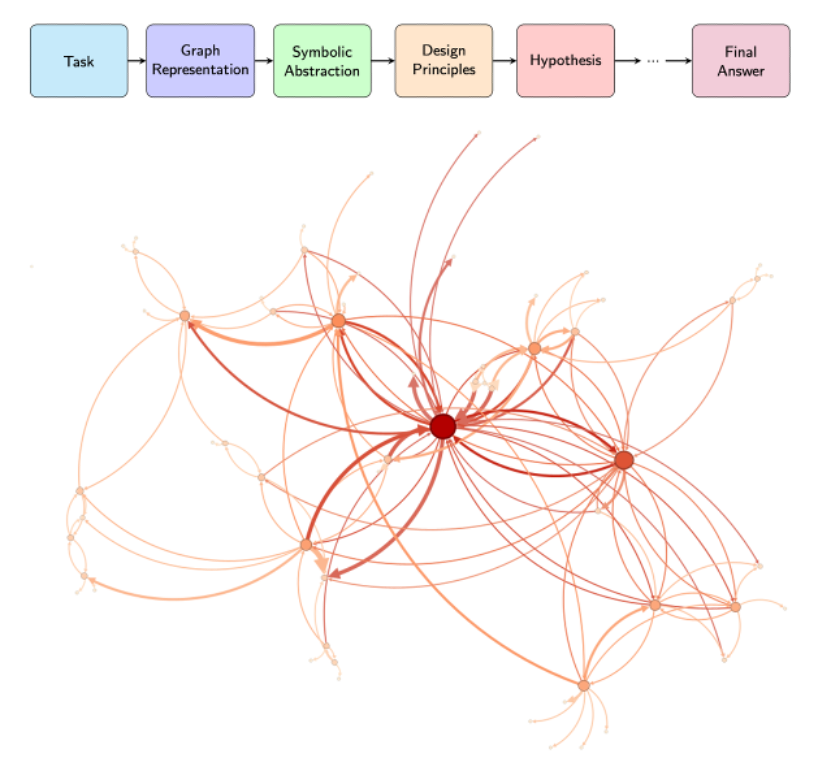

### Training phases I and II (implemented here)

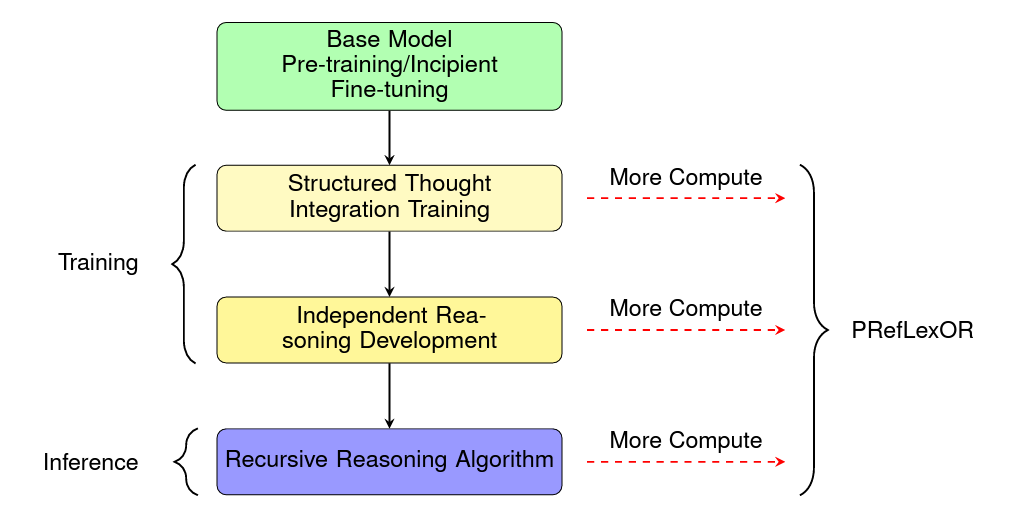 

In [1]:
import os

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tqdm.notebook import tqdm
import openai
import matplotlib.pyplot as plt
from datetime import datetime
import datasets
import multiprocessing
from accelerate import PartialState
from trl import ModelConfig, DPOConfig, DPOTrainer, ORPOConfig
from transformers import (
    TrainingArguments,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizerBase,
    Trainer,
    TrainerCallback,
    AutoConfig,
    BitsAndBytesConfig,
    DataCollator,
    is_wandb_available
)
import torch
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
import inspect
import random
import warnings
from collections import defaultdict
from contextlib import contextmanager, nullcontext
from copy import deepcopy
from functools import partial, wraps

from llama_index.core import (
    VectorStoreIndex, Document, SimpleDirectoryReader, Settings
)
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.extractors import TitleExtractor
from llama_index.core.ingestion import IngestionPipeline, IngestionCache
from llama_index.core.indices.vector_store.retrievers import VectorIndexRetriever

from datasets import load_dataset, concatenate_datasets, Dataset

# Custom imports
from utils import *
from active_trainer import *


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/miniconda3/envs/genai/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/envs/genai/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/miniconda3/envs/genai/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File 

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/miniconda3/envs/genai/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/envs/genai/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/miniconda3/envs/genai/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File 

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



/opt/miniconda3/envs/genai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'accelerate'

In [ ]:
#Set HF token if not already set
token = 'hf_.....'
from huggingface_hub import login
login(token=token)

#If you want to use OpenAI as inference engine (e.g. in Llama Index, or elsewhere), set these secrets
'''
openai_api_key = "sk-....."
openai.api_key=openai_api_key
'''

In [ ]:
think_start = '<|thinking|>'
think_end = '<|/thinking|>'

#raw dataset used, data to be expected in 'text' field
raw_data= "lamm-mit/...."

#whether or not to use LoRA to create a trainable model 
use_LoRA =True


### Start server to serve LLM, e.g. vLLM or Mistral.RS

### Additional helper functions 

In [ ]:
def process(row, manual = True):
    
    if manual:
        row["prompt"] =  f'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n{row["prompt"]}<|eot_id|>'
        row["chosen"] =  f'<|start_header_id|>assistant<|end_header_id|>\n\n{row["chosen"]}<|eot_id|>'
        row["rejected"] =f'<|start_header_id|>assistant<|end_header_id|>\n\n{row["rejected"]}<|eot_id|>'
    else:
        row["prompt"] = tokenizer.apply_chat_template   ([ {"role": "user", "content":row["prompt"]}],tokenize=False,add_generation_prompt=False )
        row["chosen"] = tokenizer.apply_chat_template   ([ {"role": "assistant", "content":row["chosen"]}],tokenize=False,add_generation_prompt=False )
        row["rejected"] = tokenizer.apply_chat_template ( [ {"role": "assistant", "content":row["rejected"]}],tokenize=False,add_generation_prompt=False )
 
    return {'prompt': row["prompt"], 'chosen': row["chosen"], 'rejected': row["rejected"], }


def generate_dataset(generate_GPT, index, topics=None, only_include_wrong_answers=False, #if set True, we'll only include wrong answers. 
                     n_questions_for_each=1,  #how many questions for each topic
                     number_nodes_to_get=2,   #how many nodes to make Q-A pair
                     
                     verbatim=False,get_rejected_from_trained_model=True,model=None, tokenizer=None,
                     nodes=None, text=None, process=None):
    data = {"prompt": [], "chosen": [], "rejected": [], "rejected_correct": []}

    if isinstance(topics, list): #topics provided as list of strings
        for topic in tqdm(topics):
            for _ in range(n_questions_for_each):
                try:
                    question, correct_response, response_trained_model = get_question_and_answers(generate=generate_GPT, 
                                                        index = index,
                                                        topic=topic, get_rejected_from_trained_model=get_rejected_from_trained_model,
                                                        number_nodes_to_get=number_nodes_to_get,  
                                                        model=model, tokenizer=tokenizer,
                                                    )
    
                    correct_answer=None
                    
                    if verbatim:
                        print ("-"*64)
                        print (">Prompt: ", question)
                        print (">Correct response: ", correct_response)
                        print (">Response model: ", response_trained_model)
                        print (">Correct? ", correct_answer)
                    if only_include_wrong_answers:
                        correct_answer =False #is_answer_correct(generate_GPT, correct_response, response_trained_model)
                    
                        if correct_answer==False:
                            #do not add if answer is correct
                            data["prompt"].append(question)
                            data["chosen"].append(correct_response)
                            data["rejected"].append(response_trained_model)
                            data["rejected_correct"].append (correct_answer)
                    else:
                        data["prompt"].append(question)
                        data["chosen"].append(correct_response)
                        data["rejected"].append(response_trained_model)
                        data["rejected_correct"].append (correct_answer)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    
    else: #no topics provided, use random nodes
        for _ in tqdm(range(topics)):
            for _ in range(n_questions_for_each):
                try:
                    question, correct_response, response_trained_model = get_question_and_answers(generate=generate_GPT, 
                                                          index = index, get_rejected_from_trained_model=get_rejected_from_trained_model,
                                                          number_nodes_to_get=number_nodes_to_get,  
                                                          model=model, tokenizer=tokenizer,
                                                    )
        
                    correct_answer=None
                    if verbatim:
                        print ("-"*64)
                        print (">Prompt: ", question)
                        print (">Correct response: ", correct_response)
                        print (">Response model: ", response_trained_model)
                        print (">Correct? ", correct_answer)
                    if only_include_wrong_answers==False:
                        
                        correct_answer=False#is_answer_correct(generate_GPT, correct_response, response_trained_model)
                        if correct_answer==False:
                            #here do not add if answer is correct
                            data["prompt"].append(question)
                            data["chosen"].append(correct_response)
                            data["rejected"].append(response_trained_model)
                            data["rejected_correct"].append (correct_answer)
                    else:
                        data["prompt"].append(question)
                        data["chosen"].append(correct_response)
                        data["rejected"].append(response_trained_model)
                        data["rejected_correct"].append (correct_answer)
               
                except Exception as e:
                    print(f"An error occurred: {e}")                    
    
    hf_dataset = datasets.Dataset.from_dict(data)
    
    if process!=None:
        hf_dataset = hf_dataset.map(
            process,
            num_proc=multiprocessing.cpu_count(),
        )
        
    return hf_dataset

### Set up Llama Index for RAG, embeddings, and other tools 

In [ ]:
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-large-en-v1.5" #or other embedding models
)

In [ ]:
# Load your dataset
dataset = datasets.load_dataset(raw_data)['train']
documents = [Document(text=dataset[i]['text']) for i in range (len (dataset))]

pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_size=1024, chunk_overlap=20),
    ],
   )

nodes = pipeline.run(documents=documents,  show_progress=True,)
index = VectorStoreIndex(nodes, show_progress=True,)
retriever = index.as_retriever()

### Load base model and create trainable version

In [ ]:
device='cuda:0'

model_name='meta-llama/Llama-3.2-3B-Instruct'

torch.cuda.empty_cache()

try:
    del model
    del tokenizer
except:
    print ()
gc.collect()
torch.cuda.empty_cache()
try:
    del ref_model
     
except:
    print ()
gc.collect()
torch.cuda.empty_cache()

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    use_cache=False,
     
    device_map="auto",
    torch_dtype =torch.bfloat16,
    attn_implementation="flash_attention_2",
    #device_map="cuda:0",
).to (device)
model.config.use_cache = False

model_name_tokenizer='lamm-mit/meta-llama-Meta-Llama-3.2-3B-Instruct-scratchpadtokenizer'
tokenizer = AutoTokenizer.from_pretrained(model_name_tokenizer, trust_remote_code=True,
                                           use_fast=False,
                                         )
pad_token='<|finetune_right_pad_id|>'
tokenizer.pad_token = pad_token
tokenizer.padding_side = "right"  

if use_LoRA:
    from peft import LoraConfig, get_peft_model

    lora_alpha = 64
    lora_dropout = 0.1
    lora_r = 64   
    peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM", #["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj"]
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "embed_tokens", #include embed/lm_head as we are defining a new token
            "lm_head",
        ],
    ) 
    model=get_peft_model(model, peft_config)
    
    model.print_trainable_parameters()
    ref_model=None
else:
    ref_model=AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        use_cache=False,
         
        device_map="auto",
        torch_dtype =torch.bfloat16,
        attn_implementation="flash_attention_2",
         
    ).to (device)
    ref_model.config.use_cache = False

tokenizer.encode (f'{think_start}{think_end}')

In [ ]:
# Setting up default values for the API key, model, and organization
generate_GPT_MistralRS = partial(
    generate_OpenAI,
    openai_api_key='NONE',   
    model='meta-llama/Llama-3.1-8B-Instruct',
    base_url="http://localhost:8000/v1"
   )

prompt='What is spider silk?'
messages=[
            {
                "role": "system",
                "content": 'You are a materials scientist with expertise in biological materials, mechanics, and related fields.',
            },
            {
                "role": "user",
                "content": prompt,
            }
        ] 

res, _ = generate_GPT_MistralRS (messages=messages)
res

### Define functions to generate graph, abstractions and other parts of the dataset on-the-fly

In [ ]:
def generate_knowledge_graph(generate_fn, query_engine, question, context, use_rag=True):
    """
    Generates a knowledge graph with core relationships and a simple abstract pattern layer.
    Uses RAG to enhance the abstract understanding.
    """
    # Generate base knowledge graph first
    concept_prompt = """
Create a focused knowledge graph for this question. Include only the most important elements:

1. Key Concepts (3-5 main concepts from the question and context)

2. Essential Relationships (using only these types):
   - IS-A: classification/type relationships
   - RELATES-TO: how concepts connect
   - INFLUENCES: how one concept affects another

Format each relationship as:
[Concept A] -[Relationship]-> [Concept B]

Question: {question}
Context: {context}
"""
    messages = [
        {"role": "system", "content": "You are a materials science expert. Create a focused knowledge graph with only the most important concepts and relationships."},
        {"role": "user", "content": concept_prompt.format(question=question, context=context)}
    ]
    
    base_graph, _ = generate_fn(messages=messages)
    
    # Use RAG to identify abstract patterns
    abstract_prompt = f"""
For this question and context, identify:
1. The general pattern of relationship between concepts (e.g., A affects B, which causes C)
2. The type of change or transformation involved (e.g., increase in X leads to decrease in Y)
3. Any key dependencies or conditions

Question: {question}
Context: {context}

Keep the response very brief and focused on the essential pattern.
"""
    
    abstract_insights = query_engine.query(abstract_prompt)
    
    # Generate abstract pattern layer
    pattern_prompt = f"""
Based on the core concepts and insights, create a simple abstract pattern.
Use α, β, γ for abstract concepts and → for relationships.

Core Knowledge Graph:
{base_graph}

Insights:
{abstract_insights.response}

Create only:
1. One abstract pattern showing the general relationship structure
2. One key transformation rule
3. One essential condition

Use simple mathematical symbols (→, ∝, ↑, ↓).
"""
    
    messages = [
        {"role": "system", "content": "Create a simple abstract pattern from the knowledge graph."},
        {"role": "user", "content": pattern_prompt}
    ]
    
    abstract_pattern, _ = generate_fn(messages=messages)
    
    return format_knowledge_graph(base_graph, abstract_pattern, abstract_insights.response)


def format_knowledge_graph(base_graph, abstract_pattern, rag_insights):
    """
    Formats the knowledge graph with its abstract pattern layer.
    """
    formatted_graph = "**Knowledge Graph**\n\n"
    
    # Core knowledge
    formatted_graph += "Core Concepts and Relationships:\n"
    formatted_graph += base_graph.strip() + "\n\n"
    
    # Abstract pattern
    formatted_graph += "Abstract Pattern:\n"
    formatted_graph += abstract_pattern.strip() + "\n\n"
    
    # RAG insights
    formatted_graph += "Pattern Context:\n"
    formatted_graph += rag_insights.strip()
    
    return formatted_graph


def get_question_and_answers(
    generate,
    index,
    topic=None,
    number_nodes_to_get=2,
    nodes=None,
    text=None,
    get_rejected_from_trained_model=True,
    model=None,
    tokenizer=None,
    use_rag=True,
    categories=None,
):
    # Keep existing categories and add Knowledge Graph
    if categories is None:
        categories = [
            "Reasoning Steps",
            "Relevant Materials or Concepts",
            "Design Principles",
            "Material Properties",
            "Hypothesis",
        ]

    # Existing context retrieval
    context = retrieve_context(index, topic, number_nodes_to_get, nodes, text)
    
    # Generate the question
    question = generate_question(generate, context)
    
    # Enhance context with RAG if enabled
    enriched_context = enhance_context_with_rag(index, question, context) if use_rag else context
    
    # Generate knowledge graph
    
    # Create query engine
    query_engine = index.as_query_engine()
    
    # Generate enhanced knowledge graph
    knowledge_graph = generate_knowledge_graph(generate, query_engine, question, enriched_context, use_rag)
    
    # Extract information for each category
    extracted_info = extract_categories(generate, categories, question, enriched_context,
                                     add_RAG=True)
    
    # Add knowledge graph to extracted info
    extracted_info = OrderedDict([("Knowledge Graph", knowledge_graph), *extracted_info.items()])

    # Assemble scratchpad with knowledge graph included
    scratchpad = assemble_scratchpad(extracted_info, '')
    
    # Generate correct and rejected answers
    correct_response = generate_correct_answer(generate, question, enriched_context, scratchpad)
    correct_response_with_scratchpad = f"{scratchpad}\n{correct_response}"
    
    rejected_answer = generate_rejected_answer(
        generate, question, get_rejected_from_trained_model, model, tokenizer
    )
    
    return question + f' Use {think_start}.', correct_response_with_scratchpad, rejected_answer


def retrieve_context(index, topic, number_nodes_to_get, nodes, text):
    if nodes is None and text is None:
        if topic:
            _, concatenated_text = get_nodes_for_topic(index, topic, number_nodes_to_get)
        else:
            _, concatenated_text = get_random_nodes(index, number_nodes_to_get)
    else:
        concatenated_text = text or " ".join([node.text for node in nodes])
    token_length=len(tokenizer.encode(concatenated_text))
    print ("Token length of tokenized node data: ", token_length)
    return concatenated_text

    
def get_random_nodes(index, number_nodes_to_get=5):
    # Get all nodes from the index
    all_nodes = list(index.docstore.docs.values())
    
    # Ensure we don't request more nodes than exist in the index
    number_nodes_to_get = min(number_nodes_to_get, len(all_nodes))
    
    # Randomly select N nodes
    random_nodes = random.sample(all_nodes, number_nodes_to_get)
    
    # Concatenate their text
    concatenated_text = " ".join([node.text for node in random_nodes])
    
    return random_nodes, concatenated_text


def generate_question(generate_fn, context):
    question_gen_query = (
        "You are a Teacher/Professor. Your task is to setup "
        "a quiz/examination. Using information in the provided context, formulate "
        "a single question that captures an important fact from the "
        "context. Restrict the question to the context information provided, "
        "and make sure this is a question that a highly trained domain expert can answer without seeing the context.\n\n"
        "Just return the question, nothing else. Do not refer to the context, a paper, names, or authors, just ask the question. "
        "Do not refer to names, persons, or specific text/context. "
        "The question must be challenging, deep, and stand on its own and query facts and expert domain knowledge. "
        "The question must NOT refer to a study, or paper, or a specific author."
    )

    messages = [
        {"role": "system", "content": 'You are a materials scientist.'},
        {
            "role": "user",
            "content": f"{question_gen_query}\n\nContext: {context}",
        },
    ]
    question, _ = generate_fn(messages=messages, temperature=0.7)
    return question.strip()


def enhance_context_with_rag(index, question, context):
    query_engine = index.as_query_engine()
    answer = query_engine.query(f"{question}\n\nProvide detailed context and reasoning.")
    enriched_context = f"{context}\nAdditional Information: {answer.response}"
    return enriched_context


def extract_categories(generate_fn, categories, question, context, index=None, add_RAG=False):
    extracted_info = {}
    for category in categories:
        prompt = f"""
Based on the context, extract the "{category}" relevant to the question, keep it brief.

Question: {question}

Context: {context}

Provide only the "{category}" without additional explanations.

If you cannot find any, respond with an empty string. Keep the answer brief, but use step-by-step reasoning and a clear explanation. 

Just provide the answer, do not refer to the context.
"""
        messages = [
            {"role": "system", "content": 'You are a helpful assistant who provides well-reasoned, but succinct responses. Act like a professor.'},
            {"role": "user", "content": prompt},
        ]
        response, _ = generate_fn(messages=messages)
        if index != None:
            prompt = f"""
Use the draft and improve the "{category}" relevant to the question.

Question: {question}

Draft: {response}

Provide only the "{category}" without additional explanations.

If you cannot find any, respond with an empty string. Keep the answer brief, but use step-by-step reasoning and a clear explanation. 

Just provide the answer, do not refer to the context.
"""
            response_RAG = query_engine.query(f"{prompt}")
            print ("Improve category with RAG")
            response=response_RAG
        extracted_info[category] = response.strip()

    if add_RAG:
        prompt = f"""
Give additional background relevant for answering the question

Question: {question}

Do not answer the question, just provide additional relevant information and insights. Keep it brief.
"""
        extracted_info['Additional Background']  = query_engine.query(f"{prompt}").response.strip()
        
    return extracted_info


def assemble_scratchpad(extracted_info, reasoning_steps):
    scratchpad = f"{think_start}\n"
    #scratchpad += "Extracted Information:\n"
    for category, content in extracted_info.items():
        scratchpad += f"**{category}**:\n\n{content}\n\n"
    #scratchpad += "\n**Reasoning Steps:**\n\n"
    #scratchpad += reasoning_steps
    scratchpad += f"{think_end}"
    return scratchpad


def generate_correct_answer(generate_fn, question, context, thinking):
    prompt = f"""
Using the context provided, answer the following question:

Question: {question}

Context: {context}

Reasoning: {thinking}

Provide a comprehensive and accurate answer.
"""
    messages = [
        {"role": "system", "content": 'You are a knowledgeable materials scientist.'},
        {"role": "user", "content": prompt},
    ]
    answer, _ = generate_fn(messages=messages)
    return answer.strip()


def generate_rejected_answer(generate_fn, question, get_from_trained_model, model, tokenizer):
    if get_from_trained_model:
        # Implement logic to generate using the trained model
        incorrect_answer, _ = generate_local_model(
            model=model,
            tokenizer=tokenizer,
            prompt=f"You provide the answer to: {question}\nThe answer is:",
            system_prompt='You are a materials scientist.',
        )
    else:
        prompt = f"""
You are to provide an incorrect answer to the question below.

Question: {question}

Do not include any reasoning or refer back to the question.

Just provide the incorrect answer.
"""
        messages = [
            {"role": "system", "content": 'You are a materials scientist.'},
            {"role": "user", "content": prompt},
        ]
        incorrect_answer, _ = generate_fn(messages=messages)
    return incorrect_answer.strip()

In [ ]:
# Example usage of the function
question, correct_ans, rejected_ans=get_question_and_answers(generate=generate_GPT_MistralRS, model=model,
                                                             tokenizer=tokenizer, index=index, topic=None, 
                                                              
                             number_nodes_to_get=3, nodes=None, text=None, 
                             get_rejected_from_trained_model=True,
                                                            )

print("Question:")
print(question)
print("\nCorrect Answer with THINKING:")
print(correct_ans)
print("\nRejected Answer:")
print(rejected_ans)

In [ ]:
# Setting up default values for the API key, model, and organization
generate_GPT_local = partial(
    generate_local_model,
    model=model, tokenizer=tokenizer,
)

prompt=f'What is spider silk? Use a {think_start}.'
messages=[
            {
                "role": "system",
                "content": 'You are a materials scientist.',
            },
            {
                "role": "user",
                "content": prompt,
            }
        ] 

res, _ = generate_GPT_local (messages=messages,max_new_tokens=128, #prepend_response=f'<|thinking|>',
                            )
res

### Phase I: Structured Thought Integration Training 

In [ ]:
FT_model_name='Graph_PReFLexOR_Phase_I_results'
model_current=FT_model_name+'_'

#How many topics are generated in each training step
topics= 50

#How many questions per topic 
num_questions_per_topic=1

#How many epochs trained in each training step
num_epochs_per_dataset_generation=3

max_prompt_length=512
max_length=1024

###############################################
cfg =  ORPOConfig(
    output_dir=FT_model_name,               # usual HF Trainer args: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.args
    num_train_epochs=1,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=2,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every .. steps
    bf16=True,                              # use bfloat16 precision
    #tf32=True,                             # use tf32          
    learning_rate=5e-5,                     # learning rate
    warmup_ratio=0,
    warmup_steps=0,
    #lr_scheduler_type="cosine",
    lr_scheduler_type="constant",
    max_prompt_length=max_prompt_length,
    remove_unused_columns=False,
    max_length=max_length,
    beta=0.1,                               # ORPO beta
    save_total_limit=3,                     # args related to saving the model...
    #save_strategy="epoch",
    save_strategy="no",
    #push_to_hub=True,                       
    hub_private_repo=True,
    #report_to=['wandb'],                    # report metrics to Weights & Biases
    hub_model_id=f'lamm-mit/{FT_model_name}',
)
###############################################

In [ ]:
if isinstance(topics, list) and all(isinstance(t, str) for t in topics):
    n_steps = len(topics) * num_questions_per_topic*num_epochs_per_dataset_generation
else:
    n_steps = topics * num_questions_per_topic*num_epochs_per_dataset_generation

trainer = PRefLexORORPOTrainer(
         model=model,
         args=cfg,
         train_dataset=None,
         #train_dataset=temp,
         tokenizer=tokenizer,
         n_steps=n_steps,  # Train for 50 steps before updating dataset
         #topics=topics,
         topics=topics,
         number_nodes_to_get=3,
         n_questions_for_each=num_questions_per_topic,
         only_include_wrong_answers=False, 
         process=process,
         generate_dataset=generate_dataset,
         generate=generate_GPT_MistralRS,  #generate_GPT_OpenAI,
         index=index,
         get_rejected_from_trained_model=True,
        )


In [ ]:
system_prompt='You are a materials scientist.'

# Training loop
num_iterations = 50
for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}/{num_iterations}")
    
    # Train for N steps
    trainer.train()
    
    print (64*"#") 
    txt='Tell me why hierarchical structures work so well.'+f' Use {think_start}.'
    #txt='What is the reported work of fracture of the nacre in the abalone shell compared to its mineral constituent?'
    output_text, _ =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                               system_prompt=system_prompt,   prepend_response=f'{think_start}',
                                   num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                                   temperature=.1,max_new_tokens=1024, messages = [], do_sample=True,
                                   )
    print (output_text)
    print (64*"-")
    txt=f'What is the relationship between materials and music?'+f' Use {think_start}.'
    #txt='What is the reported work of fracture of the nacre in the abalone shell compared to its mineral constituent?'
    output_text, messages =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                               system_prompt=system_prompt,  prepend_response=f'{think_start}',
                                   num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                                   temperature=.1,max_new_tokens=1024, messages = [], do_sample=True,
                                   )
    print (output_text)
    print (64*"-")
    txt='Tell me why hierarchical structures work so well.'+f' Use {think_start}.'
    #txt='What is the reported work of fracture of the nacre in the abalone shell compared to its mineral constituent?'
    output_text, messages =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                               system_prompt=system_prompt,  prepend_response=f'{think_start}',
                                   num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                                   temperature=.1,max_new_tokens=1024, messages = [], do_sample=True,
                                   )
    print (output_text)
    print (64*"#")
    
    trainer.update_dataset()
    
    trainer.save_model(f"./{model_current}")
    model.push_to_hub (f"lamm-mit/{model_current}", private=True)
    tokenizer.push_to_hub (f"lamm-mit/{model_current}", private=True)

    print(f"Completed iteration {iteration + 1}/{num_iterations}")

### Phase II: Independent Reasoning Development

#### First, merge adapter into base model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.cuda.empty_cache()
import gc 
try:
    del model
    del tokenizer
    del merged_model
except:
    print ()
gc.collect()
torch.cuda.empty_cache()
try:
    del ref_model
     
except:
    print ()
gc.collect()
torch.cuda.empty_cache()

model_name="lamm-mit/meta-llama-Llama-3.2-3B-Instruct-untied"
model_base = AutoModelForCausalLM.from_pretrained(model_name,     torch_dtype =torch.bfloat16,
    attn_implementation="flash_attention_2",device_map="auto",trust_remote_code=True,
    
     )
 
peft_model_id = model_current

model_base = PeftModel.from_pretrained(model_base, peft_model_id)

model = model_base.merge_and_unload()

model_name_tokenizer='lamm-mit/meta-llama-Meta-Llama-3.2-3B-Instruct-scratchpadtokenizer'

tokenizer = AutoTokenizer.from_pretrained(model_name_tokenizer, trust_remote_code=True,
                                           use_fast=False,
                                         )
pad_token='<|finetune_right_pad_id|>'
tokenizer.pad_token = pad_token
tokenizer.padding_side = "right"  

torch.cuda.empty_cache()
try:
    del model_base
     
except:
    print ()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
if use_LoRA:

    from peft import LoraConfig, get_peft_model
    lora_alpha = 64
    lora_dropout = 0.1
    lora_r = 64

    peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM", 
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            #"embed_tokens",
            #"lm_head",
        ], 
      #  modules_to_save=["embed_tokens", "lm_head"]
    ) 
    
    from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
    
    #model = prepare_model_for_kbit_training(model)
    model=get_peft_model(model, peft_config)
    
    model.print_trainable_parameters()
    ref_model=None
else:
    print ("We will not use LoRA")

    ref_model=AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        use_cache=False,
         
        device_map="auto",
        torch_dtype =torch.bfloat16,
        attn_implementation="flash_attention_2",
        #device_map="cuda:0",
    ).to (device)
    ref_model.config.use_cache = False

tokenizer.encode ('<|thinking|><|/thinking|><|scratchpad|><|/scratchpad|><|reflect|><|/reflect|><|response|><|/response|>')

In [ ]:
# Setting up default values for the API key, model, and organization
generate_GPT_local = partial(
    generate_local_model,
    model=model, tokenizer=tokenizer,
)

prompt=f'What is spider silk? Use a {think_start}.'
messages=[
            {
                "role": "system",
                "content": 'You are a materials scientist.',
            },
            {
                "role": "user",
                "content": prompt,
            }
        ] 

res, _ = generate_GPT_local (messages=messages,max_new_tokens=128, #prepend_response=f'<|thinking|>',
                            )
res

In [ ]:
txt='Tell me why hierarchical structures work so well.'+f' Use {think_start}.'

output_text, _ =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                           system_prompt='',   #prepend_response=f'{think_start}',
                               num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                               temperature=.01,max_new_tokens=1024, messages = [], do_sample=True,
                               )
print (output_text)

#### Set up PRefLexORDPOTrainer for Phase II

In [ ]:
FT_model_name='Graph_PReFLexOR_Phase_II_results'
model_current=FT_model_name+'_'

max_prompt_length=512
max_length=1024

class RewardLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.log_history:
            try:
                print ( f"Step={state.log_history[-1]['step'] }", "rewards/margins=", state.log_history[-1]['rewards/margins'] ,
                      "loss=", state.log_history[-1]['loss'],   "rewards/accuracy=", state.log_history[-1]['rewards/accuracies'] )# Get the last log entry
            except:
                print (end='')
 
cfg = DPOConfig(
    output_dir=FT_model_name,     # usual HF Trainer args: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.args
    num_train_epochs=1,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=2,          # number of steps before performing a backward/update pass
    gradient_checkpointing=False,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every .. steps
    bf16=True,                              # use bfloat16 precision
    #tf32=True,                             # use tf32          
    max_grad_norm=0.3,
    learning_rate=1e-6,                     # learning rate
    warmup_ratio=0,
    warmup_steps=0,
    #lr_scheduler_type="cosine",
    lr_scheduler_type="constant",
    max_prompt_length=512,
    max_length=2000,
    remove_unused_columns=False,
    #max_length=1024,
    beta=0.5,                               # ORPO beta
    save_total_limit=50,                     # args related to saving the model...
    save_strategy="epoch",
    #push_to_hub=True,                       
    hub_private_repo=True,
    report_to=['none'],                    # report metrics to Weights & Biases
    hub_model_id=f'lamm-mit/{FT_model_name}',
    loss_type="exo_pair",                  # Loss type for DPO
    label_smoothing=5e-3,
)

#### Define new function to generate rejected answer using current model 

In [ ]:
def generate_rejected_answer(generate_fn, question, get_from_trained_model, model, tokenizer):
    
    if get_from_trained_model:
    incorrect_answer, _ = generate_local_model(
            model=model,
            tokenizer=tokenizer,
            prompt=f"{question}"+f' Use {think_start}.',
            system_prompt='You are a materials scientist.', max_new_tokens=1500,
        )
    else:
        prompt = f"""
You are to provide an incorrect answer to the question below.

Question: {question}

Do not include any reasoning or refer back to the question.

Just provide the incorrect answer.
"""
        messages = [
            {"role": "system", "content": 'You are a materials scientist.'},
            {"role": "user", "content": prompt},
        ]
        incorrect_answer, _ = generate_fn(messages=messages)
    return incorrect_answer.strip()


In [ ]:
# Example usage  

question, correct_ans, rejected_ans=get_question_and_answers(generate=generate_GPT_MistralRS, model=model,
                                                             tokenizer=tokenizer, index=index, topic=None, #'spider silk strength', 
                             number_nodes_to_get=3, nodes=None, text=None,  
                             get_rejected_from_trained_model=True,
                                                            )

print("Question:")
print(question)
print("\nCorrect Answer with THINKING:")
print(correct_ans)
print("\nRejected Answer:")
print(rejected_ans)

In [ ]:
from datasets import load_dataset, concatenate_datasets

topics= 50
num_questions_per_topic=1
num_epochs_per_dataset_generation=1

if isinstance(topics, list) and all(isinstance(t, str) for t in topics):
    n_steps = len(topics) * num_questions_per_topic*num_epochs_per_dataset_generation
else:
    n_steps = topics * num_questions_per_topic*num_epochs_per_dataset_generation

trainer = PRefLexORDPOTrainer(
        model=model,
        ref_model=ref_model, # set to none if use LoRA
        args=cfg,

        train_dataset=None, 
        tokenizer=tokenizer,
        n_steps=n_steps,  # Train for 50 steps before updating dataset
        topics=topics,
        number_nodes_to_get=3,
        n_questions_for_each=num_questions_per_topic,
        only_include_wrong_answers=False, 
        process=process,
    generate_dataset=generate_dataset,
    generate=generate_GPT_MistralRS, #generate_GPT_OpenAI,
    get_rejected_from_trained_model=True,
    index=index,

    #OPTION 1: Only include answer in loss
    dynamic_answer_comparison = True,  
    
    #OPTION 2: Mask out all sections of thinking, to a degree (percentage indicates how much is randomly masked out)
    mask_thinking_tokens = False, 
    thinking_token_mask_percentage = .2,  # Default to masking 100% of thinking tokens

    think_start_token= '<|thinking|>', think_end_token= '<|/thinking|>',
    include_thinking_token_in_labels=True,
    callbacks=[RewardLoggingCallback()],

    )

In [ ]:
system_prompt='You are a materials scientist.'

# Training loop
num_iterations = 50

for iteration in range(num_iterations):
    print(f"Starting iteration {iteration + 1}/{num_iterations}")
    
    # Train for N steps
    trainer.train()
        
    print (64*"#")
    # Update dataset
    txt='Tell me why hierarchical structures work so well.'#+f' Use {think_start}.'
    output_text, _ =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                               system_prompt=system_prompt,   #prepend_response=f'{think_start}',
                                   num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                                   temperature=.1,max_new_tokens=1024, messages = [], do_sample=True,
                                   )
    print (output_text)
    print (64*"-")
    #trainer.update_dataset()
    txt='Tell me how the properties of flower petals can be used to write a song.'+f' Use {think_start}.'
    output_text, _ =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                               system_prompt=system_prompt,   prepend_response=f'{think_start}',
                                   num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                                   temperature=.1,max_new_tokens=1024, messages = [], do_sample=True,
                                   )
    print (output_text)
    print (64*"-")
    txt='Explain the relationship between materials and music.'+f' Use {think_start}.'
    output_text, _ =generate_local_model (model=model, tokenizer=tokenizer,  prompt=txt,
                                               system_prompt=system_prompt,   prepend_response=f'{think_start}',
                                   num_return_sequences=1,  repetition_penalty=1.0, #top_p=top_p, top_k=top_k,  
                                   temperature=.1,max_new_tokens=1024, messages = [], do_sample=True,
                                   )
    print (output_text) 
    print (64*"#")
    
    trainer.update_dataset()
    
    print(f"Completed iteration {iteration + 1}/{num_iterations}")

    trainer.save_model(f"./{model_current}")
    model.push_to_hub (f"lamm-mit/{model_current}", private=True)
    tokenizer.push_to_hub (f"lamm-mit/{model_current}", private=True)    


In [ ]:
trainer.save_model(f"./{model_current}")
model.push_to_hub (f"lamm-mit/{model_current}", private=True)
tokenizer.push_to_hub (f"lamm-mit/{model_current}", private=True)    